# Looking for Iris Murdoch's philosophy in her novels using computational literary analysis
## James Jefferies

## Table of Contents:
* [Introduction](#intro)
    * [Tool imports](#tools)
    * [The corpus of novels](#corpus)
* [Subliminal lexicon in the novels](#subliminal-lexicon-in-novels)
    * [Interpretation](#subliminal-lexicon-in-novels-interpretation)
* [Topic analysis of the philosophy works](#topical-analysis)
    * [Analysing the topic word lists](#analysing-the-topic-word-lists) 
    * [Looking for the topics in the novels](#looking-for-topics-in-novels)
    * [Interpretation of topics in the novels](#topics-in-the-novels)
* [Philosophical themes using NLTK](#philosophical-themes-using-nltk)
    * [Words from the common vocabulary](#words-from-the-common-vocabulary)
    * [Interpretation of the words from the common vocabulary](#intepretation-words-from-the-common-vocabulary)
* [Collocation](#collocation)
    * [Collocations from The Sovereignty of Good](#collocation-sog)
    * [Interpretation of The Sovereignty of Good colloctions](#interpretation-collocation-sog)
    * [Collocations from Metaphysics As A Guide To Morals](#collocation-mgm)
    * [Interpretation of the Metaphysics As A Guide To Morals collocations](#interpretation-collocation-mgm)
* [Stylometry](#stylometry)
* [Conclusions](#conclusions)
* [Works Cited](#works-cited)

## Introduction <a class="anchor" id="intro"></a>

Iris Murdoch (1919-1999) is best known for her novels, including the Booker prize winning _The Sea, The Sea_, published in 1976. In total she had 26 novels published but she was also a respected philosopher and a teacher. 

As well as many papers, the two main philosophical works she pubished, were _The Sovereignty of Good_ in 1970 and _Metaphysics as a Guide to Morals_ in 1992. This project aims to extract some of the key themes and words from the two philosophical books and then see how they appear in her novels. 

We are also going to consider a paper by Dr. Frances White, _The Gifford-driven Genesis and Subliminal Stylistic Construction of Metaphysics as a Guide to Morals_ from 2018. White considers the roots of _Metaphysics as a Guide to Morals_ in the first half of the paper, but in the second half, titled _‘Perfectly Persuasive’: Iris Murdoch’s Subliminal Lexicon_ (White 5) she discusses what she describes as the 'Subliminal Lexicon' the words which Murdoch used to persuade her readers of what she believed in regards to her philosophy.

* First we will take the subliminal lexicon and search in the 26 novels for instances of these words, before showing them with a heat map to look for patterns and interpretation. 

* Secondly we will try and derive our own lexicon from the philosophy works by analysing their text to extract key words and topics. We will see how these words also appear in the novels. 

* Thirdly we will try to find common vocabulary and collocations. We will also look at word frequencies for these words.

* Finally we will perform some stylometry analysis using the texts.




## Tool imports <a class="anchor" id="tools"></a>

In [23]:
import spacy
import os
import nltk
import seaborn as sns

from collections                     import Counter

from nltk.corpus                     import stopwords 
from nltk.tokenize                   import word_tokenize 

from sklearn.decomposition           import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition           import PCA
from scipy.cluster.hierarchy         import dendrogram, linkage

import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

### Common functions


In [24]:
# These are python functions which have been written to aid our analysis.

def removePunctuation(text):
    """Remove punctuation"""
    for punct in "`!@#$%^&*():;-’“”,\n\xa0.?\"\'–‘":
        text = text.replace(punct, ' ')
    return text

def preProcessTexts(text):
    """Lower case text and remove punctuation"""
    lowerText = text.lower()
    return removePunctuation(lowerText)

def createAdjustedDF(thisTokenDict, setOfWordsToCheck):
    """Given a token dictionary and a set of words to check, create a dataframe with the proportion of the words in each item."""
    novelCountDict = novelCounts(thisTokenDict, setOfWordsToCheck)
    novelCountDF = pd.DataFrame(novelCountDict)
    
    lengthsDict = { title: len(tokens) for title, tokens in thisTokenDict.items() }
    adjustedDF = (novelCountDF / lengthsDict)
    
    return adjustedDF

def createHeatMap(colour, thisTokenDict, setOfWords):
    """Specialised function to product proportional values for the set of words in the token dictionary. Colour sets the heat map palette."""
    df = createAdjustedDF(thisTokenDict, setOfWords).T * 100
    df['Total']= df.sum(axis=1)

    sortedDf = df.sort_values(by='Total', ascending=False)

    colourMap = sns.light_palette(colour, as_cmap=True)
    styledDf = sortedDf.style.background_gradient(cmap=colourMap)
    return (sortedDf, styledDf)

def novelCounts(thisTokenDict, wordList):
    return { title: novelCount(tokens, wordList) for title, tokens in thisTokenDict.items() }

def novelCount(tokens, wordList):
    return { word: Counter(tokens)[word] for word in wordList }   

## The corpus of novels  <a class="anchor" id="corpus"></a>

In [25]:
# The 26 Iris Murdoch novels sit in a Readings directory in my environment - we can read them all and store them in a dictionary. 
file_names = sorted(os.listdir('../Readings'))

fileDict = {}
for file_name in file_names:
    if file_name.endswith(".txt"):
        
        # The Green Knight has a different encoding, so we read that one separately.
        if file_name.endswith("knight.txt"):
            fileDict[file_name] = open('../readings/' + file_name).read()
        else:
            fileDict[file_name] = open('../readings/' + file_name, encoding='latin2').read()

imTitles = list(fileDict.keys())
imTexts = list(fileDict.values())

In [26]:
preProcessedTextDict = { name: preProcessTexts(text) for name, text in fileDict.items() }  
tokenDict = { name: nltk.word_tokenize(text) for name, text in preProcessedTextDict.items() }
rawTokenDict = { name: nltk.word_tokenize(text) for name, text in fileDict.items() }
posDict = { name: nltk.pos_tag(text) for name, text in tokenDict.items() }

# The 'subliminal lexicon' in the novels  <a class="anchor" id="subliminal-lexicon-in-novels"></a>

White suggests that instead of looking at some of the common philosophical words, "Such words include; good, truth, love, art, imagination, value, thought, consciousness, language, metaphor, imagery" (6) we should instead look at the joining words, the in-between words. 

"What are these words which we can discern? They are perfectly ordinary familiar everyday words, like ... ‘ordinary’, ‘familiar’ and ‘everyday’" (8). She goes on to add other words used for persuading and also with a spiritual root, found in _Metaphysics as a Guide to Morals_.

"There are words that Murdoch uses as a sort of iconic mantra: ‘calm’, and ‘simple’ which derive from her mentor, Plato; ‘lucid’, and ‘space’" (9)

"She includes in her philosophical lexicon theological terms, ‘grace’, redemption, salvation. She unfashionably retains the concept of the soul. She fears the ‘loss’" (10)

Let us list some of those words:

### Everyday words:

Ordinary, familiar, everyday

### Iconic mantras:

Calm, simple, lucid, space

### Theological terms:

Redemption, salvation, soul, loss

We will use all of these words to look at how often they appear within the novels.

Using the set of words from White's paper, let us see how often they appear in the novels (as a proportion of each novel's total text). This table has been sorted on word frequency in proportion to the length of the novel, so, for example, _Redemption_ features most often, proportiionally, in the 1966 novel, _The Time of Angels_

In [27]:
subliminalSet = { 'ordinary', 'everyday', 'familiar','calm', 'simple', 'lucid', 'space', 'redemption', 'salvation', 'soul','loss'}

In [28]:
subliminalDf, styledSubliminalDf = createHeatMap('green', tokenDict, subliminalSet)
styledSubliminalDf

,ordinary,redemption,simple,everyday,soul,loss,lucid,calm,space,familiar,salvation,Total
1966-time-of-the-angels.txt,0.031783,0.004890,0.029338,0.002445,0.009779,0.012224,0.001222,0.013447,0.013447,0.031783,0.004890,0.155247
1989-the-message-to-the-planet.txt,0.030306,0.000399,0.019539,0.000798,0.013558,0.005184,0.002791,0.027514,0.016349,0.012760,0.002791,0.131989
1985-the-good-apprentice.txt,0.028083,0.000484,0.014041,0.000484,0.015978,0.007747,0.004358,0.027598,0.015010,0.010168,0.004358,0.128308
1974-the-sacred-and-profane-love-machine.txt,0.030266,0.000000,0.018736,0.000721,0.007927,0.013692,0.002882,0.020177,0.007206,0.013692,0.007206,0.122505
1983-the-philosopher-s-pupil.txt,0.023146,0.000445,0.015579,0.000445,0.018249,0.012908,0.000445,0.013353,0.015579,0.012463,0.008012,0.120624
1978-the-sea-the-sea.txt,0.022570,0.000981,0.020608,0.001963,0.010304,0.007851,0.001472,0.026496,0.013248,0.009322,0.001472,0.116286
1980-nuns-and-soldiers.txt,0.012348,0.001029,0.014406,0.000000,0.011834,0.015436,0.001544,0.020581,0.020581,0.011834,0.004116,0.113708
1963-the-unicorn.txt,0.029595,0.000000,0.022197,0.001057,0.005285,0.002114,0.000000,0.017969,0.010570,0.021140,0.001057,0.110983
1993-the-green-knight.txt,0.017307,0.000509,0.008145,0.000000,0.020362,0.007636,0.001527,0.022907,0.012726,0.008654,0.002545,0.102318
1987-the-book-and-the-brotherhood.txt,0.015666,0.000000,0.015219,0.000000,0.012085,0.008952,0.001343,0.020590,0.009847,0.013876,0.003581,0.101159


## Interpretation <a class="anchor" id="subliminal-lexicon-in-novels-interpretation"></a>

From the heat map, there do seem to be some areas which correspond to a certain period of writing. 1970 to 1989 seems to have the highest proportion of the subliminal lexicon.

It is fascinating to see _The Time of The Angels_ top the list, there is certainly a lot going on in that novel, but I wouldn't have thought it a hugely philosophical book, it is though a spiritual book and the spiritual words have raised it up the list. Iris Murdoch herself, however said "I am a little worried about how far one should let the philosophy come in.
I think sometimes it comes into the centre of the plot, as it did in The Time of the Angels" (Dooley)

_The Message To The Planet_ has a 'book' as part of the plot which is "apparently some sort of philosophical, athiest, metaphysical work that is to confront all previous philosophy and move on from it.." (Martin and Rowe 149). No surprise to see it so high in this list. The other books near the top of the list, are mainly from her later period of writing, where she relaxed more into her writing. These novels are generally longer than her earlier ones.

The early novels all appear towards the bottom of the list with one exception. From reading them, there is more plot and less philosophical discourse in these novels. The philosophy is still there though. The exception being _The Unicorn_ from 1963. "_The Unicorn_ is the first of Murdoch's experiments with the Gothic form" (Martin and Rowe 61) and as is observed "mordern gothic novelists look in to the human psyche and it's obsessive desires, murderous impulses and dysfunctional fantasies in order to explore the origins of evil" (Horner 70). This exploration of the gothic may also have increased the use of the subliminal lexicon in a way in which those other early books didn't.

# Topic analysis of the philosophy works <a class="anchor" id="topical-analysis"></a>

One method for extracting some of the common theme words from the philosophical works, would be to split the text in to chapters and then use the Latent Dirichlet Allocation (LDA) method to extract some topics. We could do this for each of the two books and then pick a sensible combination of the two. Once we have these words, we can then see how they appear in the novels.


In [54]:

mgm = open('../readings/Philosophy/1992-metaphysics-as-a-guide-to-morals.txt').read()
mgmChapters = mgm.split('##')

mgmTitle = '1992-metaphysics-as-a-guide-to-morals.txt'

throwaway_chapter = mgmChapters.pop(0) # First chapter is a single newline

mgmChapterNames = [
    "1 Conceptions of Unity. Art",
    "2 Fact and Value",
    "3 Schopenhauer",
    "4 Art and Religion",
    "5 Comic and Tragic",
    "6 Consciousness and Thought – I",
    "7 Derrida and Structuralism",
    "8 Consciousness and Thought – II",
    "9 Wittgenstein and the Inner Life",
    "10 Notes on Will and Duty",
    "11 Imagination",
    "12 Morals and Politics",
    "13 The Ontological Proof",
    "14 Descartes and Kant",
    "15 Martin Buber and God",
    "16 Morality and Religion",
    "17 Axioms, Duties, Eros",
    "18 Void",
    "19 Metaphysics: a Summary"
]

sogChapterNames = [
    'The Idea of Perfection',
    'On God and Good',
    'The Sovereignty of Good over other concepts'
]

sog = open('../readings/Philosophy/1970-the-sovereignty-of-good.txt').read()
sogChapters = sog.split('##')
throwaway_chapter = sogChapters.pop(0) 

sogTitle = '1970-the-sovereignty-of-good.txt'

In [57]:
def createCountDataFrameAndWordLabels(listOfChaptersAsText, chapterNames):
    """Use the count vectorizer and produce a dense data frame of the words and chapters"""
    countVectorizer = CountVectorizer(stop_words='english', max_features=1000)
    counts = countVectorizer.fit_transform(listOfChaptersAsText)
    wordLabels = countVectorizer.get_feature_names()

    return (pd.DataFrame(counts.todense(), index=chapterNames, columns=wordLabels), wordLabels)

In [31]:
mgmDF, mgmWordLabels = createCountDataFrameAndWordLabels(mgmChapters, mgmChapterNames)
sogDF, sogWordLabels = createCountDataFrameAndWordLabels(sogChapters, sogChapterNames)

In [58]:
def getWords(topicName, topicWordMatrix): 
    return ' '.join(list(topicWordMatrix.loc[topicName].sort_values(ascending=False).head(5).index))

def workOutTopicsUsingLDA(countDF, wordLabels, n_components=5):
    """Use the Latent Dirichlet Allocation method to try and tease out some topics from the texts. Extract the common words for five different topics."""
    lda = LatentDirichletAllocation(n_components=n_components)
    ldaOut = lda.fit_transform(countDF)
    
    topicWordMatrix = pd.DataFrame(lda.components_, index=['Topic ' + str(x) for x in range(5)], columns=wordLabels)
    return [getWords(topic, topicWordMatrix) for topic in ['Topic ' + str(x) for x in range(5)]]      

In [33]:
mgmTopicsWords = workOutTopicsUsingLDA(mgmDF, mgmWordLabels)

In [34]:
sogTopicsWords = workOutTopicsUsingLDA(sogDF, sogWordLabels)

In [35]:
setOfWordsFromMGM = set(" ".join(mgmTopicsWords).split(' '))
setOfWordsFromSOG = set(" ".join(sogTopicsWords).split(' '))
setOfWordsFromBoth = setOfWordsFromMGM | setOfWordsFromSOG

## Analysing the topic word lists <a class="anchor" id="analysing-the-topic-word-lists"></a>



### Sovereignty of Good



In [36]:
for word in setOfWordsFromSOG:
    print(f"{word} ", end="")

good human energies thought art philosophy self sense moral words telling reward teaches actual love idea 

This text is much shorter, with only three chapters, producing less topic words. In fact the analysis seems to indicate that there are only three distinct topics it could extract. Interesting the words which have come out, you would expect _good_ to be present along with _moral_ and _art_ - the others seem less important for now.

### Metaphysics as a Guide To Morals

In [37]:
for word in setOfWordsFromMGM:
    print(f"{word} ", end="")

good individual art say love idea experience god inner political duty kant wittgenstein moral consciousness world language religion philosophy 

Looking at the five topics (each with five words) gives us an idea of some of the themes in the philosophy book. As one might expect, if you are a little familiar with the philosophy of Iris Murdoch, _good_ appears in 4 of the topic sets, as does _moral_. These then might be worth looking for in the novels. _Wittgenstein_ and _Kant_ pop up as other philosophers, they may appear in the novels and might be worth looking for. If nothing else, it gives us some words to check further.

### Combined

In [38]:
listOfWordsFromBoth = list(setOfWordsFromBoth)
listOfWordsFromBoth.sort()

for word in listOfWordsFromBoth:
    print(f"{word} ", end="")

actual art consciousness duty energies experience god good human idea individual inner kant language love moral philosophy political religion reward say self sense teaches telling thought wittgenstein words world 

By combining the two lists in a set, we get a full list.

### Revised list

I think being selective is going to be useful here. So, I'm going to focus on:

good, love, wittgenstein, kant, moral, thought, self, plato, individual, art, experience, consciousness

In [55]:
keyWordsFromTheTopics = { 'good', 'love', 'wittgenstein', 'kant', 'moral', 'thought', 'self', 'plato', 'individual', 'art', 'experience', 'consciousness'}

# Looking for the topics in the novels <a class="anchor" id="looking-for-topics-in-novels"></a>

By doing a simple count of appearance of the words in the texts, lets see what results we get. If we use a set of the selected topic words and look at the frequencies of their appearance.



In [56]:
keyWordsFromTheTopicsDf, styledKeyWordsFromTheTopicsDf = createHeatMap('orange', tokenDict, keyWordsFromTheTopics)
styledKeyWordsFromTheTopicsDf

,good,individual,thought,art,experience,kant,wittgenstein,self,moral,plato,love,consciousness,Total
1973-the-black-prince.txt,0.125639,0.001276,0.126914,0.077807,0.019133,0.000000,0.000638,0.046556,0.007015,0.003189,0.249364,0.019771,0.677300
1980-nuns-and-soldiers.txt,0.105991,0.001544,0.264462,0.018008,0.008747,0.000000,0.002058,0.015950,0.016465,0.000000,0.216612,0.006174,0.656009
1970-a-fairly-honourable-defeat.txt,0.120329,0.002017,0.211752,0.009411,0.010756,0.002017,0.002689,0.016806,0.010083,0.000672,0.250069,0.012772,0.649372
1968-the-nice-and-the-good.txt,0.116559,0.001608,0.283760,0.006431,0.005627,0.000000,0.000000,0.023312,0.005627,0.000804,0.188101,0.012058,0.643885
1969-bruno-s-dream.txt,0.095057,0.000000,0.209961,0.012535,0.010446,0.000000,0.001045,0.028204,0.005223,0.001045,0.227719,0.010446,0.601680
1971-an-accidental-man.txt,0.137754,0.003204,0.217844,0.006407,0.009611,0.000000,0.000000,0.016018,0.005126,0.000641,0.190293,0.012814,0.599712
1974-the-sacred-and-profane-love-machine.txt,0.112416,0.001441,0.186640,0.007206,0.005044,0.000000,0.000000,0.040355,0.008647,0.000000,0.205376,0.015854,0.582979
1985-the-good-apprentice.txt,0.108941,0.005326,0.203356,0.012589,0.007263,0.000000,0.000484,0.031956,0.007263,0.000484,0.176726,0.009199,0.563588
1976-henry-and-cato.txt,0.131923,0.002734,0.220784,0.017089,0.009570,0.000000,0.000000,0.024607,0.006152,0.002051,0.144911,0.002051,0.561871
1987-the-book-and-the-brotherhood.txt,0.106978,0.008057,0.230964,0.009847,0.004924,0.000000,0.000000,0.022828,0.004924,0.003581,0.149053,0.007162,0.548317


### Interpretation of topics in the novels <a class="anchor" id="topics-in-the-novels"></a>

Using the topic analysis words, we don't get any strikingly large usages of the words, but we do get a different pattern than using the subliminal lexicon. The older novels still appear lower down in the list but this time we get a lot of the late 1960s and 1970s novels nearer the top. The words which drive this appear to be good, love, thought and moral. Words which are feel like they should be part of Murdoch's philosophy. 

_The Black Prince_ makes an appearance at the top of this list, certainly a book exploring philosophy, experienc and art. This novel is also a first person narration which maybe allows a wider discussion of some of the common vocabulary from the philosophy works.

_Nuns and Soldiers_ gets a boost by including references to Wittgenstein, but is also one of the well rounded novels, written after _The Sea, The Sea_ looking at the light and the dark.


# Philosophical themes using NLTK <a class="anchor" id="philosophical-themes-using-nltk"></a>

We have discovered some thematic words from the two philosophy texts using topic analysis, but we also have another method we could try. If we are able to convert the texts to NLTK text, then we can use the vocab function to extract the most common words from the texts. First we'll set up a couple of functions to remove stop words and convert to NLTK text objects

In [41]:
def removeStopWordsManually(tokens):
    """Remove stop words using a list constructor"""
    stop_words = set(stopwords.words('english')) 
    return [word for word in tokens if not word in stop_words] 

def convertToNltkTexts(rawText, fileName):
    """Preprocess text, remove punctuation, lower case, word tokenise and remove stop words"""
    preProcessedText = preProcessTexts(rawText)
    tokens = nltk.word_tokenize(preProcessedText)
    tokensNoStopWords = removeStopWordsManually(tokens)
    return nltk.Text(tokensNoStopWords, name=fileName)

In [42]:
mgmNltkText = convertToNltkTexts(mgm, mgmTitle)
sogNltkText = convertToNltkTexts(sog, sogTitle)

In [43]:
def createSetFromCommonVocab(nltkTexts):
    words = []
    for nltkText in nltkTexts:
        arrayOfTuples = nltkText.vocab().most_common(10) 
        for word in arrayOfTuples:
            words.append(word[0])
            
    return set(words)

In [44]:
setFromCommonVocab = createSetFromCommonVocab([mgmNltkText, sogNltkText])
listFromCommonVocab = list(setFromCommonVocab)
listFromCommonVocab.sort()

### Words from the common vocabulary <a class="anchor" id="words-from-the-common-vocabulary"></a>


In [45]:
for word in listFromCommonVocab:
    print(f"{word} ", end="")

also art god good idea may moral one philosophy self sense us world 

As a reminder, all of the words we discovered using topic analysis were: 
    
argument art assume attempted consciousness existence finding god good idea kant language life love mind moral philosophical philosophy plato proof schopenhauer self sense thought unimportant useful wittgenstein words world  

In [46]:
setFromCommonVocabDf, styledSetFromCommonVocabDf = createHeatMap('purple', tokenDict, setFromCommonVocab)
styledSetFromCommonVocabDf

,good,art,also,god,us,sense,self,moral,may,world,one,philosophy,idea,Total
1973-the-black-prince.txt,0.125639,0.077807,0.089924,0.099490,0.093751,0.065051,0.046556,0.007015,0.088011,0.073342,0.309313,0.004464,0.044005,1.124369
1985-the-good-apprentice.txt,0.108941,0.012589,0.052776,0.074564,0.084732,0.046481,0.031956,0.007263,0.171400,0.053744,0.245480,0.001453,0.055681,0.947060
1971-an-accidental-man.txt,0.137754,0.006407,0.043569,0.082653,0.113407,0.042287,0.016018,0.005126,0.065994,0.077527,0.298574,0.004485,0.032036,0.925837
1954-under-the-net.txt,0.070955,0.006898,0.041390,0.012811,0.126142,0.030550,0.007884,0.004927,0.051245,0.041390,0.448395,0.003942,0.060115,0.906645
1964-the-italian-girl.txt,0.116331,0.016327,0.040818,0.057145,0.161231,0.063268,0.016327,0.004082,0.040818,0.044900,0.330626,0.000000,0.014286,0.906159
1983-the-philosopher-s-pupil.txt,0.109941,0.010237,0.081900,0.076113,0.068101,0.051632,0.021365,0.010237,0.052078,0.057419,0.263949,0.026706,0.052968,0.882647
1975-a-word-child.txt,0.158068,0.005183,0.061543,0.073851,0.086160,0.046643,0.018787,0.007126,0.047291,0.053121,0.252002,0.001296,0.050530,0.861600
1993-the-green-knight.txt,0.098754,0.016289,0.096718,0.065667,0.139987,0.025452,0.018326,0.006109,0.103336,0.038178,0.207690,0.002036,0.031561,0.850102
1976-henry-and-cato.txt,0.131923,0.017089,0.034861,0.133290,0.056050,0.043747,0.024607,0.006152,0.038962,0.057417,0.244708,0.003418,0.035544,0.827768
1970-a-fairly-honourable-defeat.txt,0.120329,0.009411,0.030250,0.061845,0.067223,0.053778,0.016806,0.010083,0.059828,0.063189,0.279647,0.010756,0.044367,0.827513


## Interpretation of the words from the common vocabulary <a class="anchor" id="intepretation-words-from-the-common-vocabulary"></a>


Once again the older novels appear towards the bottom of the list, except for Under The Net - the first novel published in 1954. As this interpretation is based around word counts, that is really interesting to see. The key 'common' words from her philosophy work appear frequently in her first novel before dropping and then returning for the 1970 novels.

_The Black Prince_ is at the top again of this heat map, a clear winner using these words. 

# Collocation <a class="anchor" id="collocation"></a>


Collocations are series of words that appear together in text, more than would normally be expected. Using NLTK we can derive a list of collocations for the two philosophy novels and then investigate to see whether they occur frequently in the novels.


In [47]:
def createCollocationCountDict(dictionaryTitlesTexts, collocations):
    
    collocationCountDict = {}
    for title, text in dictionaryTitlesTexts.items():
        for expression in collocations:
            if not title in collocationCountDict:
                collocationCountDict[title] = {}
        
            collocationCountDict[title][expression] = text.count(expression)
    
    return collocationCountDict

def createCollocationDataFrame(dictionaryTitlesTexts, collocations):
    collocationCountDict = createCollocationCountDict(dictionaryTitlesTexts, collocations)
    return pd.DataFrame(collocationCountDict).T

def createCollocationHeatMap(preProcessedTextDict, collocations, colour):
    collocationDF = createCollocationDataFrame(preProcessedTextDict, collocations)
    collocationDF['Total']= collocationDF.sum(axis=1)
    sortedDf = collocationDF.sort_values(by='Total', ascending=False)
    
    colourMap = sns.light_palette(colour, as_cmap=True)
    styledDf = sortedDf.style.background_gradient(cmap=colourMap)
    return styledDf

## Collocations from The Sovereignty of Good <a class="anchor" id="collocation-sog"></a>



Here are the top 10 collocations from _The Sovereignty Of Good_

In [48]:
sogCollocations = sogNltkText.collocation_list(window_size=3)[:10]

for word in sogCollocations:
    print(word)

moral philosophy
human beings
ordinary language
great art
idea perfection
concentration camp
starting point
one might
anglo saxon
simone weil


And here is a heat map showing the frequencies of when the collocations appear in the novels

In [49]:
createCollocationHeatMap(preProcessedTextDict, sogCollocations, 'pink')

,moral philosophy,human beings,ordinary language,great art,idea perfection,concentration camp,starting point,one might,anglo saxon,simone weil,Total
1970-a-fairly-honourable-defeat.txt,1,26,0,0,0,1,3,6,0,0,37
1989-the-message-to-the-planet.txt,0,8,2,2,0,5,2,13,0,0,32
1973-the-black-prince.txt,1,8,0,6,0,4,2,7,0,0,28
1980-nuns-and-soldiers.txt,0,4,0,0,0,3,3,6,0,0,16
1971-an-accidental-man.txt,0,6,1,1,0,1,1,4,0,0,14
1975-a-word-child.txt,0,7,0,0,0,1,0,5,0,0,13
1968-the-nice-and-the-good.txt,0,6,0,0,0,0,0,7,0,0,13
1958-the-bell.txt,0,5,0,0,0,0,0,7,0,0,12
1978-the-sea-the-sea.txt,0,4,0,0,0,0,0,8,0,0,12
1961-a-severed-head.txt,0,4,0,0,0,0,0,7,0,0,11


## Interpretation <a class="anchor" id="interpretation-collocation-sog"></a>

The collocations of _The Sovereignty of Good_ show a different picture to the other analysis we have been doing. The top book was published in the same year and is strongly linked with 'human beings' - the second highest collocation from _The Sovereignty of Good_. The top three have a much higher instance than the others, once again _The Message To The Planet_ and _The Black Prince_ are near the top and the former owes most of it's score to 'one may' whilst the latter scores across the board.

## Collocations from Metaphysics As A Guide To Morals <a class="anchor" id="collocation-mgm"></a>



Here are the top 10 collocations from _Metaphysics As A Guide To Morals_

In [50]:
mgmCollocations = mgmNltkText.collocation_list(window_size=3)[:10]

for word in mgmCollocations:
    print(word)

simone weil
ontological proof
fact value
categorical imperative
work art
common sense
good evil
one might
may seem
might say


And here is a heat map showing the frequencies of when the collocations appear in the novels

In [51]:
createCollocationHeatMap(preProcessedTextDict, mgmCollocations, 'violet')

,simone weil,ontological proof,fact value,categorical imperative,work art,common sense,good evil,one might,may seem,might say,Total
1989-the-message-to-the-planet.txt,0,4,0,0,0,4,0,13,5,5,31
1978-the-sea-the-sea.txt,0,2,0,0,0,3,0,8,5,3,21
1983-the-philosopher-s-pupil.txt,0,3,1,1,0,5,0,4,0,4,18
1973-the-black-prince.txt,0,0,0,0,0,1,0,7,7,1,16
1966-time-of-the-angels.txt,0,2,0,0,0,5,0,7,0,2,16
1970-a-fairly-honourable-defeat.txt,0,0,0,1,0,4,0,6,2,1,14
1961-a-severed-head.txt,0,0,0,0,0,2,0,7,3,1,13
1968-the-nice-and-the-good.txt,0,0,0,0,0,2,0,7,1,3,13
1958-the-bell.txt,0,0,0,0,0,4,0,7,0,1,12
1975-a-word-child.txt,0,0,0,0,0,1,0,5,5,0,11


## Interpretation <a class="anchor" id="interpretation-collocation-mgm"></a>

Using the collocations from _Metaphysics As A Guide To Morals_ we see _The Message To The Planet_ appear at the top of the list, a clear favourite using terms found in the philosophical work appearing a few years later. Finally _The Sea, The Sea_ makes a stronger showing, using very similar words to _The Message To The Planet_ but less frequently.

# Stylometry <a class="anchor" id="stylometry"></a>

Out of interest, running a stylometry analysis on the novels and the philosophical works might show some interesting results.



(28, 100)


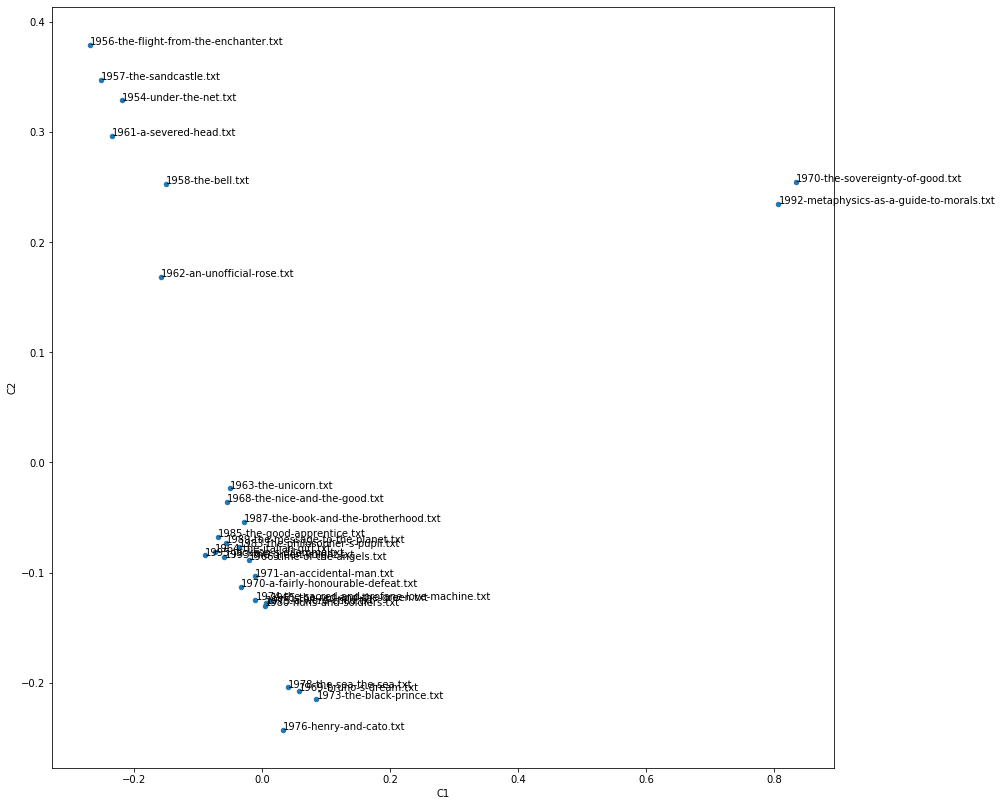

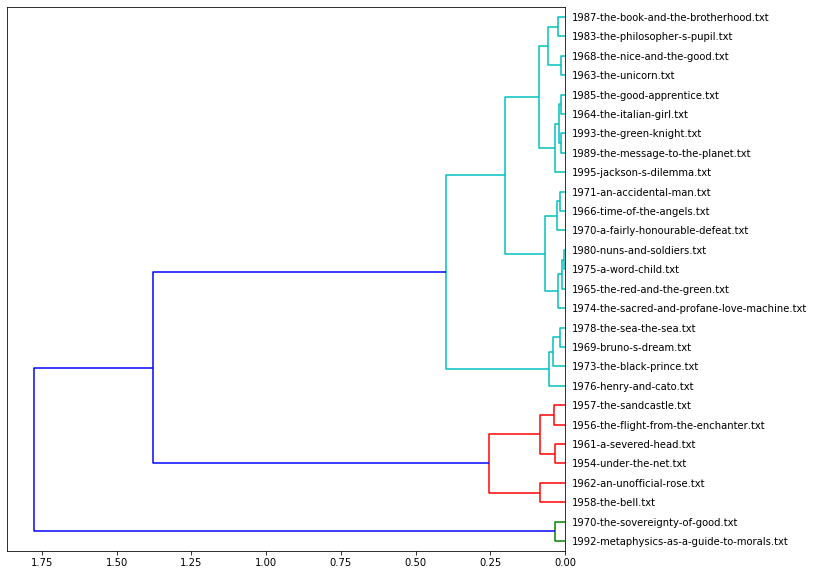

In [52]:
def plotStylometry(allTexts, allTitles, min_df=1, max_df=1.0, max_features=None):
    # Set up the vectorizer with parameters
    tfidfVectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df,stop_words='english')
    
    # Actually do the transform, allTexts is a list, so 
    # you end up with a multi-dimensional matrix
    textMatrix = tfidfVectorizer.fit_transform(allTexts)
    
    # Fill in the gaps, else it's a sparse matrix
    # to save space
    denseTextMatrix = textMatrix.todense()
    
    # For debug purposes, what is the shape of the matrix
    print(denseTextMatrix.shape)
    
    # PCA can compress the multi-dimensional matrix
    # to a 2-dimensional (in this case) matrix
    pca = PCA(n_components=2)
    textPoints = pca.fit_transform(denseTextMatrix)
    
    # Create a data frame of this two dimensional table/matrix
    # set index to be the titles and provide it with columns
    textDf = pd.DataFrame(textPoints, index=allTitles, columns=['C1','C2'])
    
    # Do a plot of the data frame - you have to give it the x, y
    ax = textDf.plot(kind='scatter', x='C1', y='C2', figsize=(14,14))

    # Annotate the points with the titles
    for title, points in textDf.iterrows():
        ax.annotate(title, points)
    
    plt.show()  
    
    links = linkage(textDf, method='ward')
    
    plt.subplots(figsize=(10, 10))
    
    _ = dendrogram(links, labels=allTitles, orientation='left')
    
    plt.show()

imTextsAndMgm = imTexts + [mgm, sog]
imTitlesAndMgm = imTitles + [mgmTitle, sogTitle]
# plotStylometry(imTexts, imTitles, min_df=1, max_df=1.0, max_features=None)
plotStylometry(imTextsAndMgm, imTitlesAndMgm, 0.5, 1.0, 100)

# Conclusions  <a class="anchor" id="conclusions"></a>

This has been a brief look using various techniques to look at how Iris Murdoch's philosophy appeared in her novels. The different techniques have highlighted some different outcomes.

Comparing the subliminal lexicon with the derived topics, it seems that the 1970s books explore some of the topics found in the philosophy, but the teaching or persuasive words which are found in the subliminal lexicon all appear more in the late novels. Is this Murdoch shifting from a researchers perspective to a teaching perspective later in her novel writing career?

Generally the older novels score much lower when looking for her philosophy. From reading the novels it is there, but from our analysis we could say that it becomes more obvious in her later, longer novels.

Our stylometry shows, as would be expected, the philosophy works out on their own with high values on the x-axis. Interestingly though, they correlate to the older novels on the y-axis - you see this too on the Dendrogram.

Of course, the terms we have used are often normal words, apart from philosophy specific terms or names, which on their own may not indicate that philosophical discourse is happening, however, combining the analysis has shown us some interesting patterns which deserve further research. 

The collocations might be the best method for looking for the philosophy, giving extra context to the words. Charting them over time would be interesting to see what changes there are based on when the philosophy texts were published.

It would be interesting to include the collection of early philosophical essays, published in 1997 _Existentialists and Mystics_ to the other two works. Also it would be fascinating to have had access to the book on Heidegger which was due to be published around the time of _The Green Knight_ "The Green Knight (1993)... is founded upon an argument between two opposing philosophies (one of which is almost always Platonic), the neo-Platonic developed through Peter Mir and the Nietzschean spectre of Lucas Graffe. (Leeson 122). 

If we were able to add the unpublished philosophical book would _The Green Knight_ move up the charts?

This project barely scratches the surface, looking for the philosophy in the novels, but it does whet the appetite for what you can do with Computational Literary Analysis.

# Works Cited  <a class="anchor" id="works-cited"></a>




White, Frances. "_The Gifford-driven Genesis and Subliminal Stylistic Construction of Metaphysics as a Guide to Morals_", 2018, pp.6-12

Martin, Priscilla and Rowe, Anne. "The Late Novels" _Iris Murdoch, A Literary Life_, Palgrave Macmillan 2010, pp. 149

Horner, Avril. "Refinements of Evil: Iris Murdoch and the Gothic" _Iris Murdoch and Morality_, Basingstoke: Palgrave Macmillan 2010, pp 70-86

Leeson, Miles. _Iris Murdoch: Philosophical Novelist_, Continuum International Publishing Group, pp 122

Dooley, Gillian ed., From a Tiny Corner in the House of Fiction, 21. Iris in informal conversation with W. K. Rose in 1968.